In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


path = "/content/drive/MyDrive/Dataset_prediction/dataset_ Sheet.csv"
df = pd.read_csv(path)
dataset = df.to_dict(orient='records')

# Q-Learning hyperparameters
alpha = 0.01
gamma = 0.9
num_episodes = 5000

# Neural Network Model
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


Q = {}
for data in dataset[1:]:
    slope = data['slope']
    action_speeds = {f'v_inc_{i}': data[f'v_inc_{i}'] for i in range(1, 6)}
    action_speeds.update({f'v_dec_{i}': data[f'v_dec_{i}'] for i in range(1, 6)})
    Q[(slope, data['Distance'])] = action_speeds

# Neural Network and Optimizer
dqn = DQN(num_inputs=2, num_actions=10)
optimizer = optim.Adam(dqn.parameters(), lr=alpha)



# Training the Q-values using Q-learning
for episode in range(num_episodes):
    for i in range(1, len(dataset) - 1):
        data = dataset[i]
        slope = data['slope']
        Distance = data['Distance']
        state = (slope, Distance)

        state_tensor = torch.tensor([float(slope), float(Distance)], dtype=torch.float)
        q_values = dqn(state_tensor)

        action_speeds = Q[state]
        action_indices = {action: list(action_speeds.keys()).index(action) for action in action_speeds}
        abs_diffs = {action: abs(q_values[action_indices[action]] - data['velocity']) for action in action_speeds}

        selected_action = min(abs_diffs, key=abs_diffs.get)
        selected_velocity = action_speeds[selected_action]

        next_data = dataset[i + 1]
        next_slope = next_data['slope']
        next_distance = next_data['Distance']
        next_state = (next_slope, next_distance)
        difference= abs(float(data['velocity']) - float(Q[state][selected_action]))

        reward = 1.0 / (1.0 + difference)

        # Update Q-values using the Q-learning formula
        Q[state][selected_action] = Q[state][selected_action] + alpha * (
            reward + gamma * max(Q[next_state].values()) - Q[state][selected_action]
        )

        optimizer.zero_grad()
        loss = F.smooth_l1_loss(q_values[action_indices[selected_action]], torch.tensor([reward + gamma * max(Q[next_state].values())]))
        loss.backward()
        optimizer.step()





<ipython-input-1-1b5a3f1160f9>:78: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(q_values[action_indices[selected_action]], torch.tensor([reward + gamma * max(Q[next_state].values())]))


Mean Absolute Percentage Error (MAPE): 6.24%
Accuracy: 93.76%


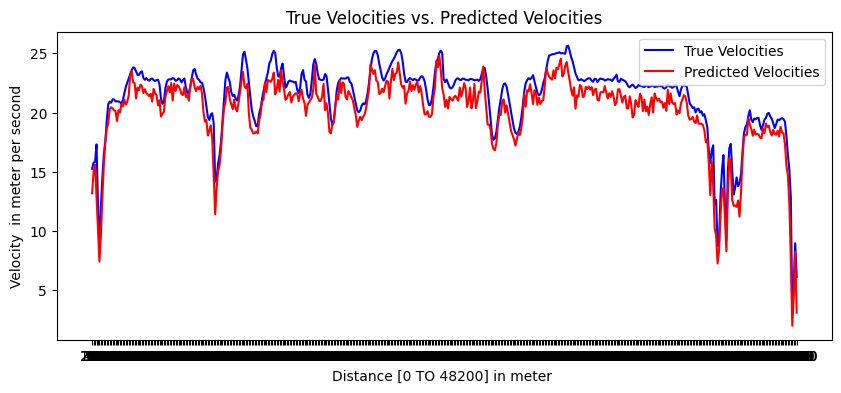

In [ ]:

true_velocities_list = [data['velocity'] for data in dataset[1:]]
predicted_velocities_list = [float(Q[(data['slope'], data['Distance'])][selected_action]) for data, selected_action in zip(dataset[1:], [min(Q[(data['slope'], data['Distance'])], key=Q[(data['slope'], data['Distance'])].get, default=None) for data in dataset[1:]])]

mape = np.mean(np.abs((np.array(true_velocities_list) - np.array(predicted_velocities_list)) / np.array(true_velocities_list))) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


# # Print Distance, Slope, and values for each distance and selected action
# for data in dataset[1:]:
#     slope = data['slope']
#     distance = data['Distance']
#     selected_action = min(Q[(slope, distance)], key=Q[(slope, distance)].get, default=None)

#     # Get the values associated with the selected action
#     selected_values = Q[(slope, distance)][selected_action]

#     print(f"Distance: {distance}, Slope: {slope},  Predicted Velocity: {selected_values}")


# Visualization: Velocity vs. Distance
distance_list = [data['Distance'] for data in dataset[1:]]
true_velocities_dict = {data['Distance']: data['velocity'] for data in dataset[1:]}
predicted_velocities_dict = {data['Distance']: float(Q[(data['slope'], data['Distance'])][selected_action]) for data, selected_action in zip(dataset[1:], [min(Q[(data['slope'], data['Distance'])], key=Q[(data['slope'], data['Distance'])].get, default=None) for data in dataset[1:]])}

plt.figure(figsize=(10, 4))
plt.plot(distance_list, true_velocities_list, label='True Velocities', color='blue')
plt.plot(distance_list, predicted_velocities_list, label='Predicted Velocities', color='red')
plt.xlabel('Distance [0 TO 48200] in meter ')
plt.ylabel('Velocity  in meter per second')
plt.xticks(distance_list)
plt.legend()
plt.title('True Velocities vs. Predicted Velocities')
plt.show()


In [ ]:
# ...

predicted_velocities_list = [float(Q[(data['slope'], data['Distance'])][selected_action]) for data, selected_action in zip(dataset[1:], [min(Q[(data['slope'], data['Distance'])], key=Q[(data['slope'], data['Distance'])].get, default=None) for data in dataset[1:]])]

mape = np.mean(np.abs((np.array(true_velocities_list) - np.array(predicted_velocities_list)) / np.array(true_velocities_list))) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

# Extracting additional data for printing
additional_data = []
for data, selected_action in zip(dataset[1:], [min(Q[(data['slope'], data['Distance'])], key=Q[(data['slope'], data['Distance'])].get, default=None) for data in dataset[1:]]):
    slope = data['slope']
    distance = data['Distance']
    selected_values = Q[(slope, distance)][selected_action]
    actual_velocity = data['velocity']
    predicted_velocity = float(selected_values)
    additional_data.append({'Slope': slope, 'Distance': distance, 'Predicted Velocity': predicted_velocity, 'Actual Velocity': actual_velocity})

# Printing the additional data
for entry in additional_data:
    print(f"Slope: {entry['Slope']}, Distance: {entry['Distance']}, Predicted Velocity: {entry['Predicted Velocity']}, Actual Velocity: {entry['Actual Velocity']}")

# Visualization: Velocity vs. Distance
# ...

# ...


Mean Absolute Percentage Error (MAPE): 6.24%
Accuracy: 93.76%
Slope: 0.0344, Distance: 100, Predicted Velocity: 13.18288019680251, Actual Velocity: 15.2582
Slope: 0.0303, Distance: 200, Predicted Velocity: 14.99873024, Actual Velocity: 15.7769
Slope: 0.0148, Distance: 300, Predicted Velocity: 15.60907977, Actual Velocity: 15.8459
Slope: 0.0054, Distance: 400, Predicted Velocity: 12.794287624603083, Actual Velocity: 17.3142
Slope: -0.0016, Distance: 500, Predicted Velocity: 10.152600210944614, Actual Velocity: 12.2179
Slope: 0.0148, Distance: 600, Predicted Velocity: 7.407265709, Actual Velocity: 8.1808
Slope: 0.0113, Distance: 700, Predicted Velocity: 9.657951103601718, Actual Velocity: 12.16
Slope: 0.0052, Distance: 800, Predicted Velocity: 12.86882116939318, Actual Velocity: 14.5017
Slope: 0.0036, Distance: 900, Predicted Velocity: 15.64853196, Actual Velocity: 16.5068
Slope: -0.0053, Distance: 1000, Predicted Velocity: 17.48259843, Actual Velocity: 17.5638
Slope: -0.0171, Distance: 

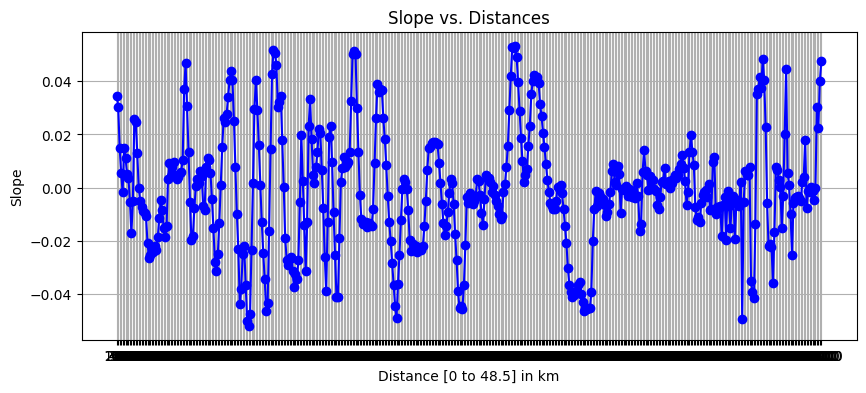

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
path = "/content/drive/MyDrive/Dataset_prediction/dataset_ Sheet.csv"
df = pd.read_csv(path)
dataset = df.to_dict(orient='records')

# Extract slope values and distances from the dataset
slope_values = [data['slope'] for data in dataset[1:]]
distances = [data['Distance'] for data in dataset[1:]]

# Plot the slope values vs. distances
plt.figure(figsize=(10, 4))
plt.plot(distances, slope_values, marker='o', linestyle='-', color='b')
plt.xlabel('Distance [0 to 48.5] in km')
plt.ylabel('Slope')
plt.title('Slope vs. Distances')
plt.xticks(distances)  # Set x-axis ticks to match dataset distances
plt.grid()
plt.show()


In [ ]:
import pandas as pd

# Create a new DataFrame to store the results
results_df = pd.DataFrame()

true_velocities_list = [data['velocity'] for data in dataset[1:]]
predicted_velocities_list = [float(Q[(data['slope'], data['Distance'])][selected_action]) for data, selected_action in zip(dataset[1:], [min(Q[(data['slope'], data['Distance'])], key=Q[(data['slope'], data['Distance'])].get, default=None) for data in dataset[1:]])]

# Add the original data and the predicted velocities to the results DataFrame
results_df['Slope'] = [data['slope'] for data in dataset[1:]]
results_df['Distance'] = [data['Distance'] for data in dataset[1:]]
results_df['True_Velocity'] = true_velocities_list
results_df['Predicted_Velocity'] = predicted_velocities_list

# Save the results DataFrame to a CSV file
results_path = "/content/drive/MyDrive/Dataset_prediction/results.csv"
results_df.to_csv(results_path, index=False)

print("Results saved to:", results_path)


Results saved to: /content/drive/MyDrive/Dataset_prediction/results.csv


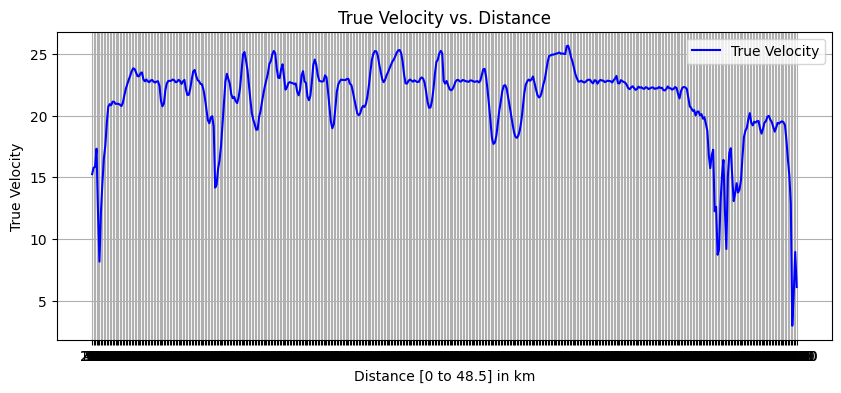

In [ ]:
import matplotlib.pyplot as plt

# Extract true velocities and distances from the dataset
true_velocities_list = [data['velocity'] for data in dataset[1:]]
distance_list = [data['Distance'] for data in dataset[1:]]

# Create the plot
plt.figure(figsize=(10,4))
plt.plot(distance_list, true_velocities_list, linestyle='-', color='blue', label='True Velocity')
plt.xlabel('Distance [0 to 48.5] in km')
plt.ylabel('True Velocity')
plt.title('True Velocity vs. Distance')
plt.legend()
plt.grid(True)

plt.xticks(distance_list)

plt.show()
